Section 1: This section ensures all the library version dependeices are met. Run the following cell and restart your run time.

!pip uninstall h5py
!pip install h5py==2.10.0

Mask R-CNN - Train cell nucleus Dataset

!pip install -U scikit-image==0.16.2

In [35]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import json
import pandas as pd

from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize

In [36]:
# # Data Path
TRAIN_PATH = 'MaskRCNN\MaskRCNN\stage1_train'
TEST_PATH = 'MaskRCNN\MaskRCNN\stage1_test'

# # Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]


Run the following cell TWICE to ensure keras 2.1.0 is installed.

In [37]:
import tensorflow
import skimage
print(tensorflow.__version__,  skimage.__version__)

import keras
keras.__version__

1.15.0 0.16.2


'2.1.0'

In [38]:
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join('MaskRCNN\MaskRCNN', "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

... done downloading pretrained model!


Configurations

In [39]:
class ShapesConfig(Config):
    """Configuration for training on the dataset.
    Derives from the base Config class and overrides values specific
    to the dataset.
    """
    # Give the configuration a recognizable name
    NAME = "shapes"

    # Train on 1 GPU and 1 images per GPU. We can put multiple images on each
    # GPU. Batch size is (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + nucleus

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 896
    IMAGE_MAX_DIM = 896

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 64, 128, 256)  # anchor side in pixels

    # Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 500

    # set number of epoch
    STEPS_PER_EPOCH = 200

    # set validation steps 
    VALIDATION_STEPS = 50
    
config = ShapesConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  896
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  896
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [896 896   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

Dataset

In [40]:
class ShapesDataset(utils.Dataset):
    
    def load_shapes(self, mode):
        
        # Add classes
        self.add_class("shapes", 1, "nucleus")
        

        if mode == "train":  
            for n, id_ in enumerate(train_ids):
                if n < int(len(train_ids) * 0.9):
                    path = TRAIN_PATH + id_
                    img_path = path + '/images/'
                    self.add_image("shapes", image_id=id_, path=img_path)
              
        if mode == "val":   
            for n, id_ in enumerate(train_ids):
                if n >= int(len(train_ids) * 0.9):
                    path = TRAIN_PATH + id_
                    img_path = path + '/images/'
                    self.add_image("shapes", image_id=id_, path=img_path)      

    def load_image(self, image_id):
        print(image_id)
        info = self.image_info[image_id]
        info = info.get("id")
       
        path = TRAIN_PATH + "/" + info
        img = imread(path + '/images/' + info + '.png')[:,:,:3]
        img = resize(img, (config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1]), mode='constant', preserve_range=True)
       
        return img

    def image_reference(self, image_id):
        """Return the shapes data of the image."""
        info = self.image_info[image_id]
        if info["source"] == "shapes":
            return info["shapes"]
        else:
            super(self.__class__).image_reference(self, image_id)

    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID.
        """
        
        info = self.image_info[image_id]
        info = info.get("id")
        path = TRAIN_PATH + "/" + info
        number_of_masks = len(next(os.walk(path + '/masks/'))[2])
        mask = np.zeros([config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1], number_of_masks], dtype=np.uint8)
        iterator = 0
        for mask_file in next(os.walk(path + '/masks/'))[2]:
            mask_ = imread(path + '/masks/' + mask_file)
            mask_ = resize(mask_, (config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1]), mode='constant', preserve_range=True)
            mask[:, :, iterator] = mask_
            iterator += 1
            # Handle occlusions
        occlusion = np.logical_not(mask[:, :, -1]).astype(np.uint8)
        for i in range(number_of_masks-2, -1, -1):
            mask[:, :, i] = mask[:, :, i] * occlusion
            occlusion = np.logical_and(occlusion, np.logical_not(mask[:, :, i]))
            
        # Map class names to class IDs.
        class_ids = np.ones((number_of_masks,), dtype=int)
        
        return mask, class_ids.astype(np.int32)

In [41]:
# Training dataset
dataset_train = ShapesDataset()
dataset_train.load_shapes("train")
dataset_train.prepare()

# Validation dataset
dataset_val = ShapesDataset()
dataset_val.load_shapes("val")
dataset_val.prepare()

75
75 19 ['BG', 'nucleus']


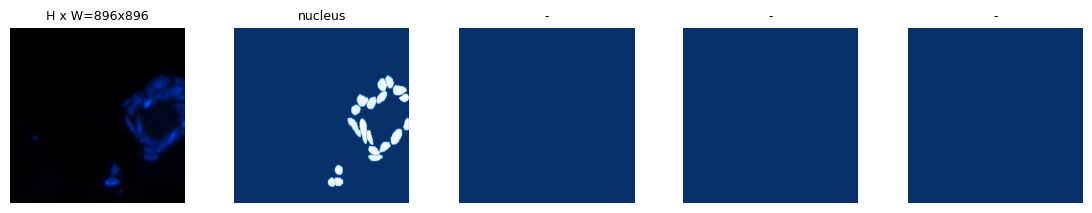

76


ValueError: could not broadcast input array from shape (896,896,3) into shape (896,896)

In [42]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    print(image_id, len(class_ids),dataset_train.class_names)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

Create Model

In [ ]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [ ]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last()[1], by_name=True)

Training

In [34]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')
#layers='all'


Starting at epoch 0. LR=0.001

Checkpoint Path: MaskRCNN\MaskRCNN\logs\shapes20230210T1921\mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4

C:\Users\CPE\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\CPE\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\CPE\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/1


RuntimeError: generator raised StopIteration

Detection

In [35]:
class InferenceConfig(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes4.h5")
#model_path = model.find_last()[1]

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  MaskRCNN\MaskRCNN\logs\mask_rcnn_shapes4.h5


In [36]:
# Test on a random image
image_id = 25 #random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =modellib.load_image_gt(dataset_val, inference_config, image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(6, 6))

25


IndexError: list index out of range

In [ ]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], figsize=(6, 6))

Evaluation

In [ ]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 30 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 30)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

In [ ]:
X_test = np.zeros((len(test_ids), config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1], 3), dtype=np.uint8)
sizes_test = []
_test_ids = []

print('Getting and resizing test images ... ')
#sys.stdout.flush()
for n, id_ in enumerate(test_ids):
    _test_ids.append([id_])
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:3]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1]), mode='constant', preserve_range=True)
    X_test[n] = img

In [ ]:
print("checking a test image with masks ...")
results = model.detect([X_test[0]], verbose=1)

r = results[0]
visualize.display_instances(X_test[0], r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], figsize=(8, 8))

In [ ]:
print("checking a test image with masks ...")
results = model.detect([X_test[0]], verbose=1)

r = results[0]
visualize.display_instances(X_test[0], r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], figsize=(8, 8))


In [ ]:
print("checking a test image with masks ...")
results = model.detect([X_test[5]], verbose=1)

r = results[0]
visualize.display_instances(X_test[5], r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], figsize=(8, 8))